# Analyze Taylor Swift Lyrics with Python


In [2]:
%matplotlib inline

import pandas as pd
import string
import seaborn as sns
import matplotlib.pyplot as plt
import collections
import nltk
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer


### 1. Load the dataset

After running the first cell to load all necessary libraries, we need to load our dataset. 
* Using pandas, load the dataset and save it as lyrics. 
* Inspect the first few rows.
* Use `.info()` to determine how many rows there are, check for missing values, and check the variable types.


In [3]:
# load dataset
lyrics = pd.read_csv("taylor_swift_lyrics_2006-2022_all.csv")

#inspect the first few rows
lyrics.head()

,album_name,track_title,track_n,lyric,line
0,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,There's something 'bout the way,1
1,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,The street looks when it's just rained,2
2,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"There's a glow off the pavement, you walk me t...",3
3,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,And you know I wanna ask you to dance right there,4
4,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"In the middle of the parking lot, yeah",5


In [4]:
#get info about the DataFrame
lyrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9370 entries, 0 to 9369
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   album_name   9370 non-null   object
 1   track_title  9370 non-null   object
 2   track_n      9370 non-null   int64 
 3   lyric        9370 non-null   object
 4   line         9370 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 366.1+ KB


### 2. Add essential data

We know that we want to explore her use of terms over years, but this dataset doesn't have years. We can either merge a dataset or manually create a new column. We have created a function for you that fills in the year based on the album name. 

* Apply this function to the `lyrics` DataFrame to create a new column.
* Inspect the first few rows of the DataFrame

In [5]:
# get a list of all the albums in this collection
lyrics['album_name'].unique()

array(['Fearless (Taylor’s Version)', 'Red (Deluxe Edition)',
       '1989 (Deluxe)', 'midnights', 'midnights (3am edition)',
       'reputation', 'Taylor Swift', 'folklore (deluxe version)', 'Lover',
       'evermore (deluxe version)', 'Speak Now (Deluxe)'], dtype=object)

In [6]:
# this is a function to map the name of the album to the year it was released
def album_release(row):  
    if row['album_name'] == 'Taylor Swift':
        return '2006'
    elif row['album_name'] == 'Fearless (Taylor’s Version)':
        return '2008'
    elif row['album_name'] == 'Speak Now (Deluxe)':
        return '2010'
    elif row['album_name'] == 'Red (Deluxe Edition)':
        return '2012'
    elif row['album_name'] == '1989 (Deluxe)':
        return '2014'
    elif row['album_name'] == 'reputation':
        return '2017'
    elif row['album_name'] == 'Lover':
        return '2019'
    elif row['album_name'] == 'evermore (deluxe version)':
        return '2020'
    #ok, we know folklore was actually released in Dec 2020, but this will make our analysis easier
    elif row['album_name'] == 'folklore (deluxe version)':
        return '2021'
    #this is slightly differently formatted because the album name is recorded two ways.
    elif 'midnights' in row['album_name']:
        return '2022'
    
    return 'No Date'


# apply the function to the album
lyrics['album_year'] = lyrics.apply(album_release, axis=1)

# inspect the first few rows of the DataFrame
print(lyrics.head())

                    album_name                  track_title  track_n  \
0  Fearless (Taylor’s Version)  Fearless (Taylor’s Version)        1   
1  Fearless (Taylor’s Version)  Fearless (Taylor’s Version)        1   
2  Fearless (Taylor’s Version)  Fearless (Taylor’s Version)        1   
3  Fearless (Taylor’s Version)  Fearless (Taylor’s Version)        1   
4  Fearless (Taylor’s Version)  Fearless (Taylor’s Version)        1   

                                               lyric  line album_year  
0                    There's something 'bout the way     1       2008  
1             The street looks when it's just rained     2       2008  
2  There's a glow off the pavement, you walk me t...     3       2008  
3  And you know I wanna ask you to dance right there     4       2008  
4             In the middle of the parking lot, yeah     5       2008  


### 3. Clean the lyric text

To accurately count keyword mentions, we need to make everything lowercase everything, remove punctuation, and exclude stop words. 

* Change everything to lower case and save the result in a new column called `clean_lyric`.
* Remove punctuation and save the result to the existing `clean_lyric` column.
* Run the code we provided to remove stopwords.
* Check to be sure you have what you expect by viewing the first few rows.

In [7]:
#lowercase
lyrics['clean_lyric']=lyrics['lyric'].str.lower()

#remove punctuation
lyrics['clean_lyric']=lyrics['clean_lyric'].str.replace('[^\w\s]', '', regex=True)

lyrics.head()

,album_name,track_title,track_n,lyric,line,album_year,clean_lyric
0,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,There's something 'bout the way,1,2008,theres something bout the way
1,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,The street looks when it's just rained,2,2008,the street looks when its just rained
2,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"There's a glow off the pavement, you walk me t...",3,2008,theres a glow off the pavement you walk me to ...
3,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,And you know I wanna ask you to dance right there,4,2008,and you know i wanna ask you to dance right there
4,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"In the middle of the parking lot, yeah",5,2008,in the middle of the parking lot yeah


In [8]:
#remove stopwords (see the next cell for illustration)
#create a small list of English stop words, feel free to edit this list
stop = ['the', 'a', 'this', 'that', 'to', 'is', 'am', 'was', 'were', 'be', 'being', 'been']


#there are three steps in one here - explained below
#we make a list of words with `.split()`
#then we remove all the words in our list
#then we join the words back together into a string
lyrics['clean_lyric'] = lyrics['clean_lyric'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))


In [9]:
# inspect the first few rows of the DataFrame
lyrics.head()

,album_name,track_title,track_n,lyric,line,album_year,clean_lyric
0,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,There's something 'bout the way,1,2008,theres something bout way
1,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,The street looks when it's just rained,2,2008,street looks when its just rained
2,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"There's a glow off the pavement, you walk me t...",3,2008,theres glow off pavement you walk me car
3,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,And you know I wanna ask you to dance right there,4,2008,and you know i wanna ask you dance right there
4,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"In the middle of the parking lot, yeah",5,2008,in middle of parking lot yeah


### The next 4 cells are for illustration only

In [10]:
#see what `.split()` does
lyrics['clean_lyric_list'] = lyrics['clean_lyric'].apply(lambda x: x.split())
print(lyrics.head())

                    album_name                  track_title  track_n  \
0  Fearless (Taylor’s Version)  Fearless (Taylor’s Version)        1   
1  Fearless (Taylor’s Version)  Fearless (Taylor’s Version)        1   
2  Fearless (Taylor’s Version)  Fearless (Taylor’s Version)        1   
3  Fearless (Taylor’s Version)  Fearless (Taylor’s Version)        1   
4  Fearless (Taylor’s Version)  Fearless (Taylor’s Version)        1   

                                               lyric  line album_year  \
0                    There's something 'bout the way     1       2008   
1             The street looks when it's just rained     2       2008   
2  There's a glow off the pavement, you walk me t...     3       2008   
3  And you know I wanna ask you to dance right there     4       2008   
4             In the middle of the parking lot, yeah     5       2008   

                                      clean_lyric  \
0                       theres something bout way   
1               street

In [11]:
#see what `.join()` does
lyrics['clean_lyric_list_rejoined'] = lyrics['clean_lyric_list'].apply(lambda x: ' '.join(x))
print(lyrics.head())

                    album_name                  track_title  track_n  \
0  Fearless (Taylor’s Version)  Fearless (Taylor’s Version)        1   
1  Fearless (Taylor’s Version)  Fearless (Taylor’s Version)        1   
2  Fearless (Taylor’s Version)  Fearless (Taylor’s Version)        1   
3  Fearless (Taylor’s Version)  Fearless (Taylor’s Version)        1   
4  Fearless (Taylor’s Version)  Fearless (Taylor’s Version)        1   

                                               lyric  line album_year  \
0                    There's something 'bout the way     1       2008   
1             The street looks when it's just rained     2       2008   
2  There's a glow off the pavement, you walk me t...     3       2008   
3  And you know I wanna ask you to dance right there     4       2008   
4             In the middle of the parking lot, yeah     5       2008   

                                      clean_lyric  \
0                       theres something bout way   
1               street

In [12]:
#remove those illustration columns
lyrics.drop(['clean_lyric_list', 'clean_lyric_list_rejoined'], axis=1, inplace=True)
print(lyrics.head())

                    album_name                  track_title  track_n  \
0  Fearless (Taylor’s Version)  Fearless (Taylor’s Version)        1   
1  Fearless (Taylor’s Version)  Fearless (Taylor’s Version)        1   
2  Fearless (Taylor’s Version)  Fearless (Taylor’s Version)        1   
3  Fearless (Taylor’s Version)  Fearless (Taylor’s Version)        1   
4  Fearless (Taylor’s Version)  Fearless (Taylor’s Version)        1   

                                               lyric  line album_year  \
0                    There's something 'bout the way     1       2008   
1             The street looks when it's just rained     2       2008   
2  There's a glow off the pavement, you walk me t...     3       2008   
3  And you know I wanna ask you to dance right there     4       2008   
4             In the middle of the parking lot, yeah     5       2008   

                                      clean_lyric  
0                       theres something bout way  
1               street l

In [13]:
#there are many pre-built lists of stopwords, including one from sklearn.
#Most exclude too many words to be appropriate for song lyric analysis.
from sklearn.feature_extraction import text
skl_stop = text.ENGLISH_STOP_WORDS
print(skl_stop)

frozenset({'they', 'sometime', 'hence', 'her', 'other', 'beside', 'has', 'them', 'last', 'further', 'by', 'part', 'two', 'cant', 'indeed', 'whereupon', 'hereupon', 'been', 'whom', 'thru', 'put', 'formerly', 'although', 'neither', 'than', 'off', 'still', 'itself', 'whenever', 'which', 'it', 'without', 'amongst', 'mine', 'a', 'bill', 'be', 'much', 'so', 'the', 'sometimes', 'during', 'thereby', 'find', 'there', 'almost', 'back', 'anyway', 'upon', 'five', 'once', 'call', 'at', 'on', 'someone', 'system', 'mill', 'somewhere', 'anywhere', 'amount', 'these', 'hereafter', 'their', 'found', 'how', 'however', 'no', 'keep', 'many', 'something', 'hasnt', 'into', 'ever', 'have', 'every', 'anyhow', 'became', 'few', 'go', 'very', 'nevertheless', 'already', 'due', 'whereas', 'whereafter', 'latter', 'where', 'within', 'three', 'our', 'along', 'anyone', 'below', 'nor', 'not', 'front', 'now', 'enough', 'third', 'also', 'eleven', 'somehow', 'his', 'nobody', 'whereby', 'against', 'each', 'herein', 'give', '

### 4. Find keyword mentions

Because we are most interested in "midnight", we will first count how many times midnight occurs in Taylor Swift's lyrics. 

* Create a new column to indicate if a lyric has "midnight" in it.
* Check how many times midnight occurrs

In [14]:
#create a new column to reflect if the lyrics contain midnight
lyrics['midnight']=lyrics['clean_lyric'].str.contains('midnight')
lyrics['midnight'].sum()

20

### 5. Expand the keyword list

Midnight might not be the only way that Taylor Swift has talked about night. We need to expand our list. We've made a list of night words and day words. Feel free to add or remove words to make the list your own. 

* Join the lists into a regular expression string using the `.join()` function and the `|` to indicate "or"
* Create a new column for each word category (day, night, time) that evaluates the clean lyrics for the presence of the words in your regular expression.
* Count how many times the words appeared and print the result to the screen
* Inspect the first few rows of the lyrics DataFrame to be sure it looks as you expect

In [15]:
#night, day, and other time-related words
night = ['night','midnight', 'dawn', 'dusk', 'evening', 'late', 'dark', '1am', '2am', '3am', '4am']
day = ['day', 'morning', 'light', 'sun', 'dawn', 'noon', 'golden', 'bright']
time = ['today', 'tomorrow', 'yesterday']

In [16]:
#create a regular expression string for each list of words
night_regex='|'.join(night)
day_regex='|'.join(day)
time_regex='|'.join(time)

#create a new column for each category of words

lyrics['has_night']=lyrics['clean_lyric'].str.contains(night_regex, case=False, regex=True)
lyrics['has_day']=lyrics['clean_lyric'].str.contains(day_regex, case= False, regex=True)
lyrics['has_time']=lyrics['clean_lyric'].str.contains(time_regex, case=False, regex=True)

#count the number of times each category of word appears in the lyrics

night_count=sum(lyrics['has_night'])
day_count=sum(lyrics['has_day'])
time_count=sum(lyrics['has_time'])

#print the count of each word category

print('Occurrences of night-realted words:',night_count)
print('Occurrences of day-related words:', day_count)
print('Occurrences of time-realted words:', time_count)


Occurrences of night-realted words: 287
Occurrences of day-related words: 387
Occurrences of time-realted words: 35


In [17]:
#inspect the first few rows
lyrics.head()

,album_name,track_title,track_n,lyric,line,album_year,clean_lyric,midnight,has_night,has_day,has_time
0,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,There's something 'bout the way,1,2008,theres something bout way,False,False,False,False
1,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,The street looks when it's just rained,2,2008,street looks when its just rained,False,False,False,False
2,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"There's a glow off the pavement, you walk me t...",3,2008,theres glow off pavement you walk me car,False,False,False,False
3,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,And you know I wanna ask you to dance right there,4,2008,and you know i wanna ask you dance right there,False,False,False,False
4,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"In the middle of the parking lot, yeah",5,2008,in middle of parking lot yeah,False,False,False,False


### 6. Visualize how Taylor Swift's mentions of time have changed over time.

Now that we know that she has referenced time, we can see if that has changed, and if she has been dropping any hints about her upcoming album. 
* Create a new dataframe called `yearly_mentions` that groups her mentions by year, and takes the sum of the other columns. Reset the index on this DataFrame to make it easier to use with matplotlib
* Create a line chart in matplotlib showing the night mentions over time.

In [18]:
#create a new dataframe for yearly mentions that groups mentions by year
yearly_mentions=lyrics.groupby('album_year')[['has_night','has_day','has_time']].sum()
yearly_mentions.reset_index(inplace=True)
yearly_mentions.head()

,album_year,has_night,has_day,has_time
0,2006,19,25,3
1,2008,42,65,20
2,2010,31,53,4
3,2012,48,53,7
4,2014,27,41,0


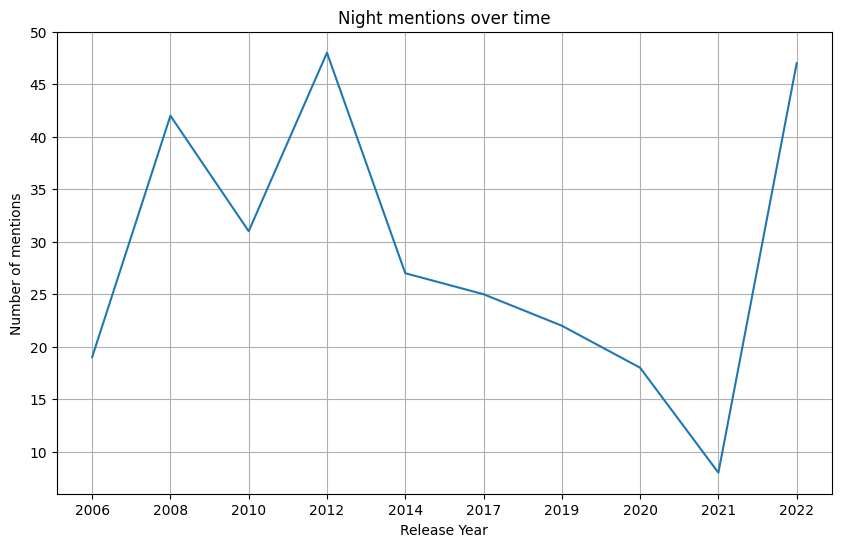

In [19]:
#plot the mentions of night over years
plt.figure(figsize=(10,6))
plt.plot(yearly_mentions['album_year'], yearly_mentions['has_night'])
plt.title('Night mentions over time')
plt.xlabel('Release Year')
plt.ylabel('Number of mentions')
plt.grid(True)

### 7. What albums are the most night/day focused?
Now that we have a table of counts, it's very easy to figure out which albums have the most mentions of day or night. But our DataFrame only has the years, not the album names. We need to add those back in.
* Run the code that reinstates the album name for this dataframe.
* Use `.sort_values()` to order the yearly_mentions table and find which year has the most mentions of night.
* Sort the day column as well.

In [20]:
#reinstate the album name
#read the album_year_name.csv
year_name = pd.read_csv('album_year_name.csv')

#sort both dataframes by year
yearly_mentions.sort_values(by='album_year', ascending=True, inplace=True)
year_name.sort_values(by='album_year', ascending=True, inplace=True)

#add the new column for album name
yearly_mentions['album_name'] = year_name['album_name']

In [21]:
#sort the lyrics by the night column to find the albums with the most night references
yearly_mentions.sort_values(by='has_night', ascending=False)

,album_year,has_night,has_day,has_time,album_name
3,2012,48,53,7,reputation
9,2022,47,24,0,Midnights
1,2008,42,65,20,Red (Deluxe Edition)
2,2010,31,53,4,1989 (Deluxe)
4,2014,27,41,0,Taylor Swift
5,2017,25,25,0,folklore (deluxe version)
6,2019,22,46,0,Lover
0,2006,19,25,3,Fearless (Taylor’s Version)
7,2020,18,38,0,evermore (deluxe version)
8,2021,8,17,1,Speak Now (Deluxe)


In [22]:
#sort the lyrics by the day column to find the albums with the most day references
yearly_mentions.sort_values(by='has_day', ascending=False)

,album_year,has_night,has_day,has_time,album_name
1,2008,42,65,20,Red (Deluxe Edition)
2,2010,31,53,4,1989 (Deluxe)
3,2012,48,53,7,reputation
6,2019,22,46,0,Lover
4,2014,27,41,0,Taylor Swift
7,2020,18,38,0,evermore (deluxe version)
0,2006,19,25,3,Fearless (Taylor’s Version)
5,2017,25,25,0,folklore (deluxe version)
9,2022,47,24,0,Midnights
8,2021,8,17,1,Speak Now (Deluxe)


### 8. Compare day to night mentions
* Create another line chart with both the night mentions and the day mentions

Text(0.5, 0, 'Album Year')

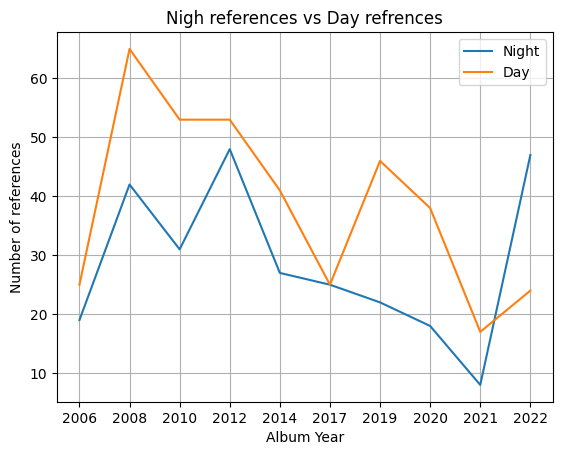

In [23]:
#create a plot with one line showing number of night references by year 
#and another line with the number of day references by year
plt.plot(yearly_mentions['album_year'], yearly_mentions['has_night'], label = 'Night')
plt.plot(yearly_mentions['album_year'], yearly_mentions['has_day'], label = 'Day')
plt.legend()
plt.grid(True)
plt.title('Nigh references vs Day refrences')
plt.ylabel('Number of references')
plt.xlabel('Album Year')

### 9. Investigate position of day vs. night mentions within albums
Maybe her references to time aren't always about the year that she released the album, but the ebb and flow of the album itself. Let's plot where, within each album, references to day and night occur.

* Create a variable that indicates the position of a lyric within an album. Call this 'position'.
* Create a new dataframe called positional_mentions that groups her mentions by album position, and takes the sum of the other columns. Reset the index on this DataFrame to make it easier to use with matplotlib.
* Create a line chart in matplotlib showing the night and day mentions as a position within the album.


In [24]:
#create a position variable that includes both the track number and line number
lyrics['position'] = lyrics['track_n'].astype(str) + '-' + lyrics['line'].astype(str)

#create a new DataFrame that is grouped by position
positional_mentions = lyrics.groupby('position').sum().reset_index()

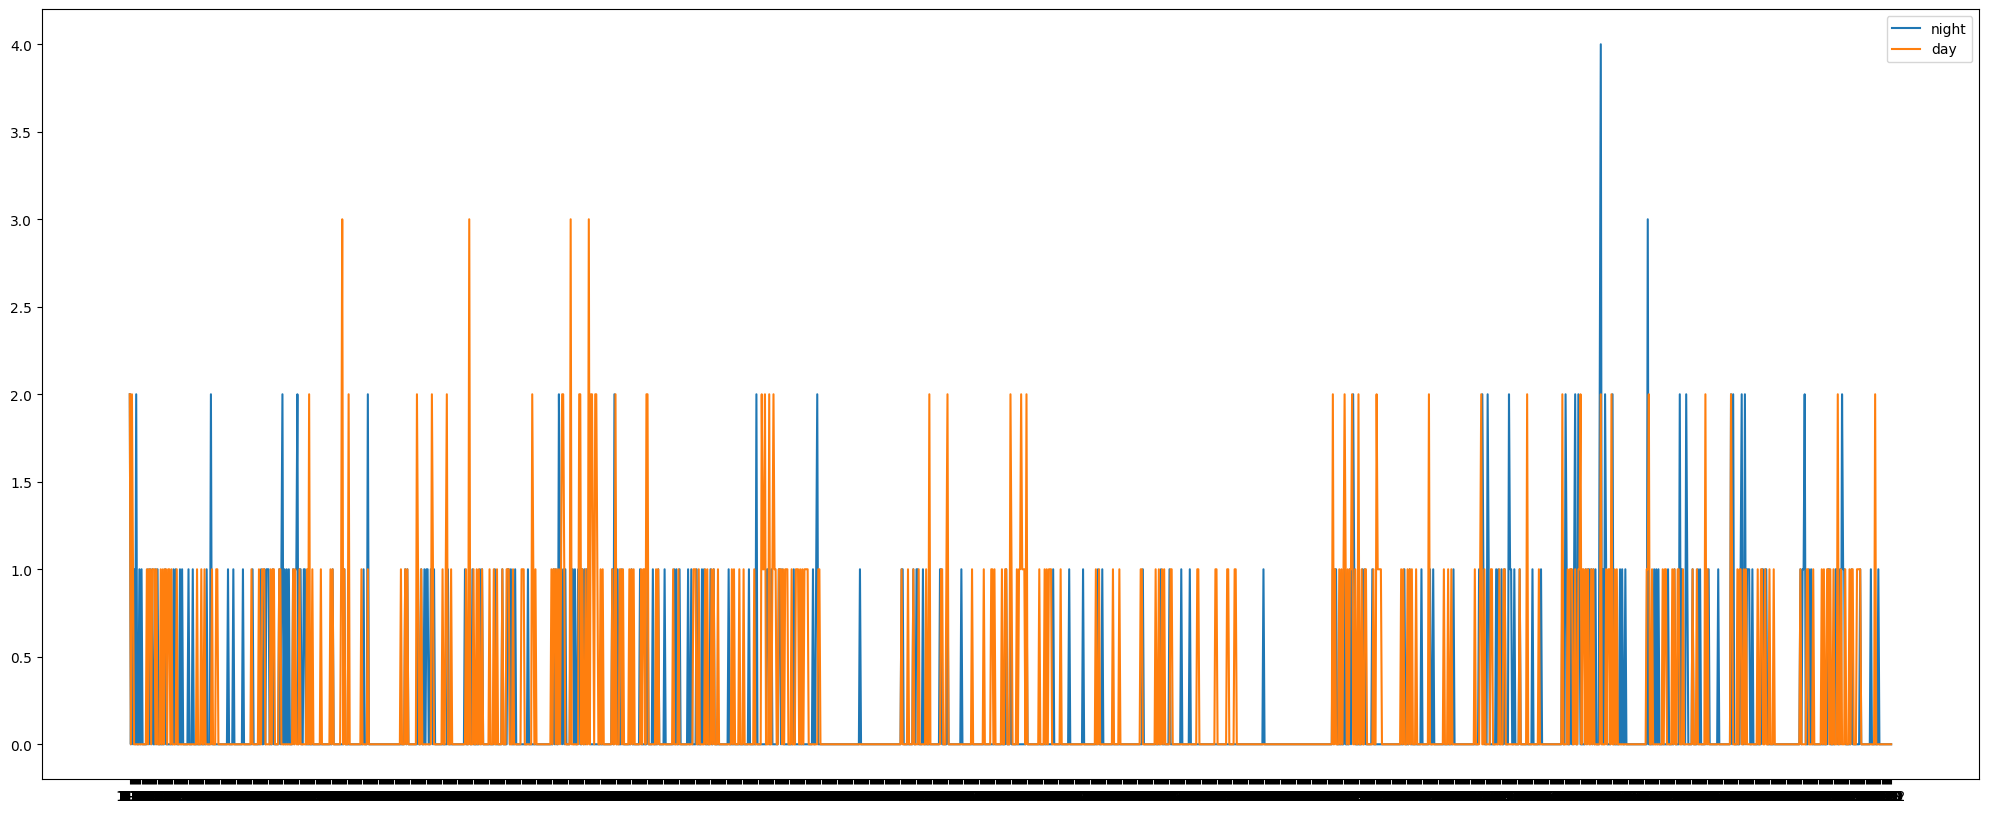

In [25]:
#increase the size of the plot 
fig = plt.gcf()
fig.set_size_inches(25,10)

#create a plot with two lines to show frequency of day vs. night references by position in the album
plt.plot(positional_mentions['position'], positional_mentions['has_night'], label = 'night')
plt.plot(positional_mentions['position'], positional_mentions['has_day'], label = 'day')
plt.legend()
plt.show()

### 10. Tokenize the Lyrics
It's great to know how much she has focused on day and night, but we would also like to do a little more sophisticated analysis. Before we can work with our cleaned lyrics, we will have to tokenize them. Tokenization is a special way of breaking up words that is a little more nuanced than just using white space. The output is a list of words that we can then perform text analysis on.

We will use the `word_tokenize` function from NLTK (the Natural Language ToolKit), and apply it to every row in our DataFrame with a lambda expression.

* Run the cell to tokenize the cleaned lyrics.
* Inspect the first few rows of the lyrics DataFrame
* Create a list of all the tokens in the lyrics_tok column into one list
* Use the Counter function from the collections package to count the number of times each word appears
* Sort the resulting dictionary


In [26]:
#run this cell to tokenize the words in the clean_lyric column
lyrics['lyrics_tok'] = lyrics['clean_lyric'].str.split(' ')

In [27]:
#inspect the first few lines
lyrics.head()

,album_name,track_title,track_n,lyric,line,album_year,clean_lyric,midnight,has_night,has_day,has_time,position,lyrics_tok
0,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,There's something 'bout the way,1,2008,theres something bout way,False,False,False,False,1-1,"[theres, something, bout, way]"
1,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,The street looks when it's just rained,2,2008,street looks when its just rained,False,False,False,False,1-2,"[street, looks, when, its, just, rained]"
2,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"There's a glow off the pavement, you walk me t...",3,2008,theres glow off pavement you walk me car,False,False,False,False,1-3,"[theres, glow, off, pavement, you, walk, me, car]"
3,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,And you know I wanna ask you to dance right there,4,2008,and you know i wanna ask you dance right there,False,False,False,False,1-4,"[and, you, know, i, wanna, ask, you, dance, ri..."
4,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"In the middle of the parking lot, yeah",5,2008,in middle of parking lot yeah,False,False,False,False,1-5,"[in, middle, of, parking, lot, yeah]"


In [28]:
#determine what words overall are the most frequently used words
#create a list of all the words in the lyrics_tok column
word_list = [word for list_ in lyrics['lyrics_tok'] for word in list_]

#use the counter function to count the number of times each word appears
word_frequency = collections.Counter(word_list)
#sort the word frequencies to find out the most common words she's used. 
word_frequency = sorted(word_frequency.items(), key=lambda x: x[1], reverse=True)
#call the word frequency
word_frequency

[('you', 3061),
 ('i', 2911),
 ('and', 1844),
 ('me', 1153),
 ('it', 1030),
 ('in', 1003),
 ('my', 927),
 ('your', 689),
 ('of', 667),
 ('all', 590),
 ('but', 581),
 ('im', 568),
 ('like', 552),
 ('on', 539),
 ('we', 538),
 ('know', 477),
 ('so', 454),
 ('oh', 447),
 ('its', 444),
 ('dont', 433),
 ('when', 417),
 ('never', 384),
 ('just', 374),
 ('youre', 367),
 ('for', 348),
 ('with', 332),
 ('love', 324),
 ('now', 321),
 ('what', 320),
 ('up', 305),
 ('out', 287),
 ('time', 286),
 ('cause', 283),
 ('if', 276),
 ('at', 276),
 ('back', 276),
 ('no', 239),
 ('are', 230),
 ('one', 222),
 ('do', 220),
 ('down', 218),
 ('got', 214),
 ('say', 212),
 ('see', 211),
 ('think', 202),
 ('they', 197),
 ('baby', 191),
 ('want', 189),
 ('can', 188),
 ('go', 188),
 ('not', 177),
 ('come', 175),
 ('could', 174),
 ('wanna', 170),
 ('have', 169),
 ('there', 168),
 ('right', 166),
 ('yeah', 166),
 ('ill', 165),
 ('he', 165),
 ('cant', 164),
 ('said', 158),
 ('ever', 150),
 ('get', 145),
 ('would', 144),

### 11. Analyze Lyric Sentiment

To better understand how she thinks and feels about day and night, we want to know which one she writes about more favorably. 

We are going to use the pre-trained sentiment classifier that comes with NLTK. It's it trained on tweets and therefore best for short text. It return 4 values: positive, negative, neutral, and compound. Compound will be of special interest to us. It is the normalized sum of positive and negative. 

* Run the sample sentiment analyzer cell to see how the SentimentIntensityAnalyzer works.
* Apply the sia sentiment analyzer to the clean_lyric column of the DataFrame with a lambda expression
* Run the cell that transforms the dictionary into columns of the DataFrame

In [29]:
#run this cell to add a package from NLTK for our sentiment analyzer.
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/ccuser/nltk_data...


True

In [30]:
#run this cell to see how the sentiment analyzer works
sia = SentimentIntensityAnalyzer()
sia.polarity_scores("I love Taylor Swift!")

{'neg': 0.0, 'neu': 0.137, 'pos': 0.863, 'compound': 0.7424}

In [31]:
#create a new column called polarity and apply the sia method to the clean_lyric column with a lambda expression
lyrics['polarity'] = lyrics['clean_lyric'].apply(lambda x: sia.polarity_scores(x))
lyrics.head()

,album_name,track_title,track_n,lyric,line,album_year,clean_lyric,midnight,has_night,has_day,has_time,position,lyrics_tok,polarity
0,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,There's something 'bout the way,1,2008,theres something bout way,False,False,False,False,1-1,"[theres, something, bout, way]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
1,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,The street looks when it's just rained,2,2008,street looks when its just rained,False,False,False,False,1-2,"[street, looks, when, its, just, rained]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
2,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"There's a glow off the pavement, you walk me t...",3,2008,theres glow off pavement you walk me car,False,False,False,False,1-3,"[theres, glow, off, pavement, you, walk, me, car]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
3,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,And you know I wanna ask you to dance right there,4,2008,and you know i wanna ask you dance right there,False,False,False,False,1-4,"[and, you, know, i, wanna, ask, you, dance, ri...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
4,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"In the middle of the parking lot, yeah",5,2008,in middle of parking lot yeah,False,False,False,False,1-5,"[in, middle, of, parking, lot, yeah]","{'neg': 0.0, 'neu': 0.694, 'pos': 0.306, 'comp..."


In [32]:
#run this cell to transform the polarity dictionary into columns of the DataFrame
lyrics[['neg', 'neu', 'pos', 'compound']] = lyrics['polarity'].apply(pd.Series)
lyrics.drop('polarity', axis=1)

,album_name,track_title,track_n,lyric,line,album_year,clean_lyric,midnight,has_night,has_day,has_time,position,lyrics_tok,neg,neu,pos,compound
0,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,There's something 'bout the way,1,2008,theres something bout way,False,False,False,False,1-1,"[theres, something, bout, way]",0.000,1.000,0.000,0.0000
1,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,The street looks when it's just rained,2,2008,street looks when its just rained,False,False,False,False,1-2,"[street, looks, when, its, just, rained]",0.000,1.000,0.000,0.0000
2,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"There's a glow off the pavement, you walk me t...",3,2008,theres glow off pavement you walk me car,False,False,False,False,1-3,"[theres, glow, off, pavement, you, walk, me, car]",0.000,1.000,0.000,0.0000
3,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,And you know I wanna ask you to dance right there,4,2008,and you know i wanna ask you dance right there,False,False,False,False,1-4,"[and, you, know, i, wanna, ask, you, dance, ri...",0.000,1.000,0.000,0.0000
4,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"In the middle of the parking lot, yeah",5,2008,in middle of parking lot yeah,False,False,False,False,1-5,"[in, middle, of, parking, lot, yeah]",0.000,0.694,0.306,0.2960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9365,Speak Now (Deluxe),Superman,17,I'll be right here on the ground,51,2010,ill right here on ground,False,False,False,False,17-51,"[ill, right, here, on, ground]",0.412,0.588,0.000,-0.4215
9366,Speak Now (Deluxe),Superman,17,When you come back down,52,2010,when you come back down,False,False,False,False,17-52,"[when, you, come, back, down]",0.000,1.000,0.000,0.0000
9367,Speak Now (Deluxe),Superman,17,"La, la, la, la, la, la",53,2010,la la la la la la,False,False,False,False,17-53,"[la, la, la, la, la, la]",0.000,1.000,0.000,0.0000
9368,Speak Now (Deluxe),Superman,17,"La, la, la, la, la, la",54,2010,la la la la la la,False,False,False,False,17-54,"[la, la, la, la, la, la]",0.000,1.000,0.000,0.0000


In [33]:
#inspect the first few rows
lyrics.head()

,album_name,track_title,track_n,lyric,line,album_year,clean_lyric,midnight,has_night,has_day,has_time,position,lyrics_tok,polarity,neg,neu,pos,compound
0,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,There's something 'bout the way,1,2008,theres something bout way,False,False,False,False,1-1,"[theres, something, bout, way]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,1.000,0.000,0.000
1,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,The street looks when it's just rained,2,2008,street looks when its just rained,False,False,False,False,1-2,"[street, looks, when, its, just, rained]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,1.000,0.000,0.000
2,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"There's a glow off the pavement, you walk me t...",3,2008,theres glow off pavement you walk me car,False,False,False,False,1-3,"[theres, glow, off, pavement, you, walk, me, car]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,1.000,0.000,0.000
3,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,And you know I wanna ask you to dance right there,4,2008,and you know i wanna ask you dance right there,False,False,False,False,1-4,"[and, you, know, i, wanna, ask, you, dance, ri...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,1.000,0.000,0.000
4,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"In the middle of the parking lot, yeah",5,2008,in middle of parking lot yeah,False,False,False,False,1-5,"[in, middle, of, parking, lot, yeah]","{'neg': 0.0, 'neu': 0.694, 'pos': 0.306, 'comp...",0.0,0.694,0.306,0.296


### 12. Corpus Sentiment Analysis

Now that we have sentiment for all of her lyrics, let's learn more about her overall sentiment, as well as how that has change throughout her career. 
* Use the pos, neg, and compound columns to calculate the overall sentiment of her entire collection, and print the result.
* Use the groupby function and matplotlib to visualize the overall sentiment of her albums over time 

In [34]:
#calculate overall sentiment for pos, neg, sentiment
pos = sum(lyrics['pos'])
neg = sum(lyrics['neg'])
compound = sum(lyrics['compound'])

#print the overall sentiments
print("positive: ", pos)
print("negative: ", neg)
print("compound: ", compound)

positive:  1235.1130000000007
negative:  799.3239999999996
compound:  485.8486000000021


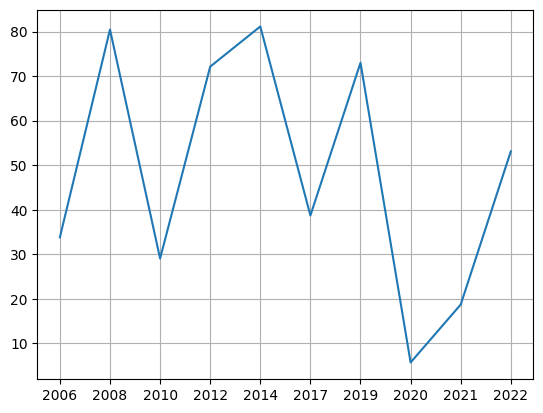

In [35]:
#create a new DataFrame using the groupby method for the album_year
yearly_sentiment = lyrics.groupby('album_year').sum().reset_index()
#visualize sentiment over time 
plt.plot(yearly_sentiment['album_year'], yearly_sentiment['compound'])
plt.grid(True)
plt.show()

### 13. Day or Night? Positive or Negative
Finally the big reveal. Does Taylor Swift write more positively about day or night? 
* Create two DataFrames: one for all the lyrics that mention night and one for all the lyrics that mention day.
* Check that each DataFrame has the right number of values with the `len()` function
* Calculate the sentiment for both night and day using the compound value and print them.

In [36]:
#create a DataFrame filtered for only night mentions
night = lyrics[lyrics['has_night']==True]

#create a DataFrame filtered for only day mentions
day = lyrics[lyrics['has_day']==True]

#print the length of the night and day DataFrames
print("night: ",len(night))
print("day: ",len(day))

night:  287
day:  387


In [37]:
#calculate the sentiment of each day and night DataFrame from the compound values
night_sentiment = night['compound'].sum()
day_sentiment = day['compound'].sum()

#print the results
print("night sentiment: ", night_sentiment)
print("day_sentiment: ", day_sentiment)

night sentiment:  19.7677
day_sentiment:  26.58


She's still overall more positive in her sentiment about day than night! 